In [19]:
#Imports
# import matplotlib.pyplot as plt
# from matplotlib import gridspec
# import tensorflow as tf 
# from tensorflow.keras.preprocessing import image_dataset_from_directory
# import numpy as np
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)


2.6.0


My First Visual Studio Code, Tensorflow, & Jupyter Notebook Project

Code copied from https://www.kaggle.com/ryanholbrook/custom-convnets

In [20]:

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')



# Load training and validation sets
ds_train_ = tf.keras.preprocessing.image_dataset_from_directory(
    './car_truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = tf.keras.preprocessing.image_dataset_from_directory(
    './car_truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 2000 files belonging to 2 classes.
Found 1909 files belonging to 2 classes.


Load Pretrained Base

In [21]:
pretrained_base = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=[128,128,3],
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
pretrained_base.trainable = False

Attach Head

In [22]:


# Pretrained base model

# model = keras.Sequential([
#     pretrained_base,
#     layers.Flatten(),
#     layers.Dense(6, activation='relu'),
#     layers.Dense(1, activation='sigmoid'),
# ])

# Custom base  0.720796 val_binary_accuracy

model = keras.Sequential([

    # First Convolutional Block
    layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same',
                  # give the input dimensions in the first layer
                  # [height, width, color channels(RGB)]
                  input_shape=[128, 128, 3]),
    layers.MaxPool2D(),

    # Second Convolutional Block
    layers.Conv2D(filters=64, kernel_size=5, activation="relu", padding='same'),
    layers.MaxPool2D(),

    # Third Convolutional Block
    layers.Conv2D(filters=128, kernel_size=5, activation="relu", padding='same'),
    layers.MaxPool2D(),

    # Fourth Convolutional Block
    layers.Conv2D(filters=256, kernel_size=5, activation="relu", padding='same'),
    layers.MaxPool2D(),

    # Classifier Head
    layers.Flatten(),
    layers.Dense(units=6, activation="relu"),
    layers.Dense(units=1, activation="sigmoid"),
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 128, 128, 32)      2432      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 64)        51264     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 128)       204928    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 256)      

Train

In [23]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30,
    verbose=1,
)

Epoch 1/30
26/32 [=======================>......] - ETA: 7s - loss: 0.7046 - binary_accuracy: 0.5673

0     0.563122
1     0.563122
2     0.563122
3     0.563122
4     0.563122
5     0.563122
6     0.563122
7     0.563122
8     0.563122
9     0.607124
10    0.665794
11    0.685699
12    0.692509
13    0.682556
14    0.690414
15    0.714510
16    0.721320
17    0.729178
18    0.721844
19    0.737035
20    0.709796
21    0.722892
22    0.727082
23    0.729701
24    0.718177
25    0.676794
26    0.702462
27    0.723939
28    0.726558
29    0.720796
Name: val_binary_accuracy, dtype: float64


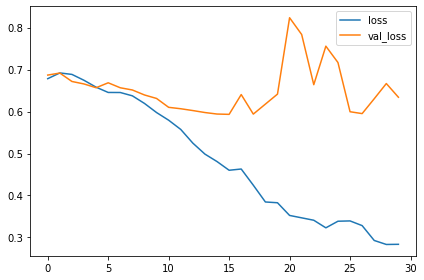

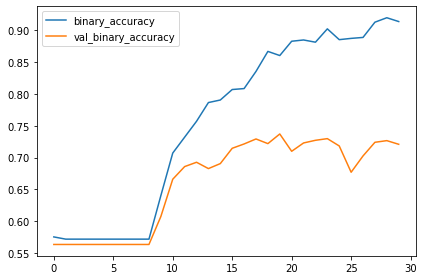

In [ ]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
print(history_frame.val_binary_accuracy)
